In [1]:
#import modules
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning import Trainer
from pytorch_lightning import Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import optuna
from optuna.integration import PyTorchLightningPruningCallback

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.patches import Ellipse

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')



Selected device: cpu


In [2]:
#### ## Autoencoder 

class AutoEncoder_optuna(pl.LightningModule):
    def __init__(self, trial):
    #initialize all the parameters
        super().__init__()
                                                                         
        encoded_space_dim = trial.suggest_int('encoded_space_dim', 50, 100) 
        n_channels = trial.suggest_int('n_channels', 5, 10)                
        
        self.trial = trial
        
        # Encoder
        self.encoder = nn.Sequential( # First convolutional layer
                                      # --> img size = (28-3+2*1)/2+1= 15x15 
                                      nn.Conv2d(1, n_channels, kernel_size=3, padding=1, stride=2),
                                      nn.ReLU(),
                                      # Second convolutional layer
                                      # --> img size = (15-3+2*1)/2+1= 8x8 
                                      nn.Conv2d(n_channels, 2*n_channels, kernel_size=3, padding=1, stride=2),
                                      nn.ReLU(),
                                      # Third convolutional layer
                                      # --> img size = (8-3+2*0)/2+1= 3x3
                                      nn.Conv2d(2*n_channels, 4*n_channels, kernel_size=3, padding=0, stride=2),
                                      nn.ReLU(),
                                      # Flatten layer
                                      nn.Flatten(start_dim=1),
                                      # First linear layer
                                      # number of input units = (img size)x(4*n_channels) = 36*n_channels
                                      nn.Linear(36*n_channels, 64), # arbitrary number of output units
                                      nn.ReLU(),
                                      # Second linear layer (output layer)
                                      nn.Linear(64, encoded_space_dim)
                                    )
        # Decoder
        self.decoder =  nn.Sequential( # First linear layer
                                       nn.Linear(encoded_space_dim, 64), 
                                       nn.ReLU(True),
                                       # Second linear layer
                                       # number of input units = (img size)x(4*n_channels) = 36*n_channels
                                       nn.Linear(64, 36*n_channels), 
                                       nn.ReLU(True),
                                       # Unflatten, fix images dimensions: 4*n_channels, 3x3 imgs 
                                       nn.Unflatten(dim=1, unflattened_size=(4*n_channels, 3, 3)),
                                       # First transposed convolution
                                       # --> img size = (3-1)*2-2*0+3-1+0+1 = 7x7
                                       nn.ConvTranspose2d(4*n_channels, 2*n_channels, kernel_size=3, 
                                                           output_padding=0, stride=2),
                                        nn.ReLU(True),
                                        # Second transposed convolution
                                       # --> img size = (7-1)*2-2*1+3-1+1+1 = 14x14
                                        nn.ConvTranspose2d(2*n_channels, n_channels, kernel_size=3, 
                                                           output_padding=1, padding=1, stride=2),
                                        nn.ReLU(True),
                                        # Third transposed convolution
                                       # --> img size = (14-1)*2-2*1+3-1+1+1 = 28x28
                                        nn.ConvTranspose2d(n_channels, 1, kernel_size=3, 
                                                           output_padding=1, padding=1, stride=2),
                                        # To obtain an output in [0,1]
                                        nn.Sigmoid()
                                    )
        self.configure_loss(loss_func)
        
    def forward(self, x):
        
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
      
        x, y = batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        train_loss = self.loss_func(x_hat, x)
        self.log('train_loss', train_loss.item())
        return train_loss
    
    def validation_step(self, batch, batch_idx, loss_name='valid_loss'): 
     
        x, y = batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        val_loss = self.loss_func(x_hat, x)
        self.log(loss_name, val_loss.item(), prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx, loss_name='test_loss')

    def configure_optimizers(self):
        opt = self.trial.suggest_categorical('optimizer', ['sgd', 'Adam'])
        lr  = self.trial.suggest_float('learning_rate', 5e-5, 1e-2, log=True)
        wd  = self.trial.suggest_float('weight_decay', 5e-7, 5e-5, log=True)
        mom = self.trial.suggest_uniform('momentum', 0.6, 0.9)
        if opt=='sgd':
            optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=mom, weight_decay=wd)
        elif opt=='Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=wd)
            
        return optimizer
    
    def configure_loss(self, loss_func):
        self.loss_func = loss_func
        
        
        
        
        
        
        
class MetricsCallback(Callback):

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append(trainer.callback_metrics)

In [3]:
def objective(trial):
    
    checkpoint_callback = pl.callbacks.ModelCheckpoint( monitor="valid_loss" )

    metrics_callback = MetricsCallback()
    
    trainer = pl.Trainer( logger=False,
                          max_epochs=50,
                          gpus=-1 if torch.cuda.is_available() else None,
                          callbacks=[ metrics_callback],
                         )

    model = AutoEncoder_optuna(trial)
    trainer.fit(model, train_load, valid_load)
    
    return metrics_callback.metrics[-1]["valid_loss"].item()

In [8]:
class AutoEncoder(pl.LightningModule):

    def __init__(self, params):

        super().__init__()
                                                                          
        encoded_space_dim = params['encoded_space_dim']
        n_channels = params['n_channels']
        
        # Encoder
        self.encoder = nn.Sequential( # First convolutional layer
                                      # --> img size = (28-3+2*1)/2+1= 15x15 
                                      nn.Conv2d(1, n_channels, kernel_size=3, padding=1, stride=2),
                                      nn.ReLU(),
                                      # Second convolutional layer
                                      # --> img size = (15-3+2*1)/2+1= 8x8 
                                      nn.Conv2d(n_channels, 2*n_channels, kernel_size=3, padding=1, stride=2),
                                      nn.ReLU(),
                                      # Third convolutional layer
                                      # --> img size = (8-3+2*0)/2+1= 3x3
                                      nn.Conv2d(2*n_channels, 4*n_channels, kernel_size=3, padding=0, stride=2),
                                      nn.ReLU(),
                                      # Flatten layer
                                      nn.Flatten(start_dim=1),
                                      # First linear layer
                                      # number of input units = (img size)x(4*n_channels) = 36*n_channels
                                      nn.Linear(36*n_channels, 64), # arbitrary number of output units
                                      nn.ReLU(),
                                      # Second linear layer (output layer)
                                      nn.Linear(64, encoded_space_dim)
                                    )
        # Decoder
        self.decoder =  nn.Sequential( # First linear layer
                                       nn.Linear(encoded_space_dim, 64), 
                                       nn.ReLU(True),
                                       # Second linear layer
                                       # number of input units = (img size)x(4*n_channels) = 36*n_channels
                                       nn.Linear(64, 36*n_channels), 
                                       nn.ReLU(True),
                                       # Unflatten, fix images dimensions: 4*n_channels, 3x3 imgs 
                                       nn.Unflatten(dim=1, unflattened_size=(4*n_channels, 3, 3)),
                                       # First transposed convolution
                                       # --> img size = (3-1)*2-2*0+3-1+0+1 = 7x7
                                       nn.ConvTranspose2d(4*n_channels, 2*n_channels, kernel_size=3, 
                                                           output_padding=0, stride=2),
                                        nn.ReLU(True),
                                        # Second transposed convolution
                                       # --> img size = (7-1)*2-2*1+3-1+1+1 = 14x14
                                        nn.ConvTranspose2d(2*n_channels, n_channels, kernel_size=3, 
                                                           output_padding=1, padding=1, stride=2),
                                        nn.ReLU(True),
                                        # Third transposed convolution
                                       # --> img size = (14-1)*2-2*1+3-1+1+1 = 28x28
                                        nn.ConvTranspose2d(n_channels, 1, kernel_size=3, 
                                                           output_padding=1, padding=1, stride=2),
                                        # To obtain an output in [0,1]
                                        nn.Sigmoid()
                                    )
        self.configure_loss(loss_func)
        
    def forward(self, x):
        
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):

        x, y = batch
        # x /= 255. # for having values in (0,1]
        z = self.encoder(x)
        x_hat = self.decoder(z)
        train_loss = F.mse_loss(x_hat, x)
        self.log('train_loss', train_loss)
        return train_loss
    
    def validation_step(self, batch, batch_idx, loss_name='valid_loss'): 

        x, y = batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        val_loss = self.loss_func(x_hat, x)
        self.log(loss_name, val_loss, prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx, loss_name='test_loss')


    def configure_optimizers(self):
        lr  = 0.0020790239718170896
        wd  = 1.3769965924344375e-06
        mom = 0.6684346922233818
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=wd)
        return optimizer
    
    def configure_loss(self, loss_func):
        self.loss_func = loss_func
        
        
        
        
        
class AddGaussianNoise():

    def __init__(self, mean : float = 0., std : float = 1., clip : bool = True):
        
        self.std = std
        self.mean = mean
        self.clip = clip
    
    def __call__(self, tensor : 'torch.tensor'):
        
        noisy_tensor = tensor + torch.randn(tensor.size(), device=tensor.device) * (self.std ** 0.5) + self.mean
        
        if self.clip:
            return torch.clamp(noisy_tensor, min=0., max=1.)
        else:
            return noisy_tensor
        
class AddSaltPepperNoise(): 

    def __init__(self, amount : float = 0.05, s_vs_p : float = 0.5, clip : bool = True):
        
        self.amount = amount
        self.s_vs_p = s_vs_p
        self.clip = clip
    
    def __call__(self, tensor : 'torch.tensor'):
        
        affected_by_noise = torch.rand_like(tensor) < self.amount
        salted = torch.rand_like(tensor) < self.s_vs_p
        peppered = ~salted

        noisy_tensor = torch.clone(tensor)
        noisy_tensor[affected_by_noise & salted] = 1
        noisy_tensor[affected_by_noise & peppered] = 0

        if self.clip:
            return torch.clamp(noisy_tensor, min=0., max=1.)
        else:
            return noisy_tensor


        
        
        
        
class Dataset_noise(torch.utils.data.Dataset):
    
    def __init__(self, dataset : "torch.utils.data.Dataset", noise_transform : "torchvision.transforms"):

        self.dataset = dataset
        self.noise_transform = noise_transform

    def __getitem__(self, index): 
        x, y = self.dataset[index][0], self.dataset[index][1]
        if self.noise_transform == None:
            x_noisy = x
        else:
            x_noisy = self.noise_transform(x)
    
        return x, x_noisy, y

    def __len__(self):
        return len(self.dataset) 
    
    
    
    
class Denoiser(pl.LightningModule):

    def __init__(self, params):

        super().__init__()
                                                                          
        encoded_space_dim = params['encoded_space_dim']
        n_channels = params['n_channels']
        
        # Encoder
        self.encoder = nn.Sequential( # First convolutional layer
                                      # --> img size = (28-3+2*1)/2+1= 15x15 
                                      nn.Conv2d(1, n_channels, kernel_size=3, padding=1, stride=2),
                                      nn.ReLU(),
                                      # Second convolutional layer
                                      # --> img size = (15-3+2*1)/2+1= 8x8 
                                      nn.Conv2d(n_channels, 2*n_channels, kernel_size=3, padding=1, stride=2),
                                      nn.ReLU(),
                                      # Third convolutional layer
                                      # --> img size = (8-3+2*0)/2+1= 3x3
                                      nn.Conv2d(2*n_channels, 4*n_channels, kernel_size=3, padding=0, stride=2),
                                      nn.ReLU(),
                                      # Flatten layer
                                      nn.Flatten(start_dim=1),
                                      # First linear layer
                                      # number of input units = (img size)x(4*n_channels) = 36*n_channels
                                      nn.Linear(36*n_channels, 64), # arbitrary number of output units
                                      nn.ReLU(),
                                      # Second linear layer (output layer)
                                      nn.Linear(64, encoded_space_dim)
                                    )
        # Decoder
        self.decoder =  nn.Sequential( # First linear layer
                                       nn.Linear(encoded_space_dim, 64), 
                                       nn.ReLU(True),
                                       # Second linear layer
                                       # number of input units = (img size)x(4*n_channels) = 36*n_channels
                                       nn.Linear(64, 36*n_channels), 
                                       nn.ReLU(True),
                                       # Unflatten, fix images dimensions: 4*n_channels, 3x3 imgs 
                                       nn.Unflatten(dim=1, unflattened_size=(4*n_channels, 3, 3)),
                                       # First transposed convolution
                                       # --> img size = (3-1)*2-2*0+3-1+0+1 = 7x7
                                       nn.ConvTranspose2d(4*n_channels, 2*n_channels, kernel_size=3, 
                                                           output_padding=0, stride=2),
                                        nn.ReLU(True),
                                        # Second transposed convolution
                                       # --> img size = (7-1)*2-2*1+3-1+1+1 = 14x14
                                        nn.ConvTranspose2d(2*n_channels, n_channels, kernel_size=3, 
                                                           output_padding=1, padding=1, stride=2),
                                        nn.ReLU(True),
                                        # Third transposed convolution
                                       # --> img size = (14-1)*2-2*1+3-1+1+1 = 28x28
                                        nn.ConvTranspose2d(n_channels, 1, kernel_size=3, 
                                                           output_padding=1, padding=1, stride=2),
                                        # To obtain an output in [0,1]
                                        nn.Sigmoid()
                                    )
        self.configure_loss(loss_func)

    def forward(self, x):
        
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        
        x, x_noise, y = batch  # consider noise
        z = self.encoder(x_noise)
        x_hat = self.decoder(z)
        train_loss = self.loss_func(x_hat, x)
        self.log('train_loss', train_loss)
        return train_loss
    
    def validation_step(self, batch, batch_idx, loss_name='valid_loss'): 
        # Similarly to the training_step we define the validation_step 
        x, x_noise, y = batch
        z = self.encoder(x_noise)
        x_hat = self.decoder(z)
        val_loss = self.loss_func(x_hat, x)
        self.log(loss_name, val_loss, prog_bar=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx, loss_name='test_loss')

    def configure_optimizers(self):
        lr  = 0.0020790239718170896
        wd  = 1.3769965924344375e-06
        mom = 0.6684346922233818
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=wd)
        return optimizer
    
    def configure_loss(self, loss_func):
        self.loss_func = loss_func
        
class Supervised_decoder(pl.LightningModule):

    def __init__(self, encoded_space_dim, pre_net):

        super().__init__()
        self.encoder = pre_net.encoder
        self.fine_tuner =  nn.Sequential( nn.Linear(encoded_space_dim, 64),
                                          nn.ReLU(True),
                                          nn.Linear(64, 10),
                                          nn.LogSoftmax()
                                         )
        
        self.accuracy = torchmetrics.Accuracy()
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fine_tuner(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        train_loss = self.loss_func(z, y)
        self.log('train_loss', train_loss)
        return train_loss
    
    def validation_step(self, batch, batch_idx, loss_name='valid_loss'):
        x, y = batch
        z = self.forward(x)
        valid_loss = self.loss_func(z, y)
        self.log(loss_name, valid_loss, prog_bar=True)
        return valid_loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        z = self.forward(x)
        self.log('accuracy', self.accuracy(z, y), prog_bar=True)
        return self.accuracy(z, y)

    def configure_optimizers(self):
        lr  = 0.0020790239718170896
        wd  = 1.3769965924344375e-06
        mom = 0.6684346922233818
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=wd)
        return optimizer
    
    def configure_loss(self, loss_func):
        self.loss_func = loss_func
        
        
        
        
        
        
        
class VariationalAE(pl.LightningModule):

    def __init__(self, params):

        super().__init__()
                                                                          
        encoded_space_dim = params['encoded_space_dim']
        n_channels = params['n_channels']
        
        # Encoder
        self.encoder = nn.Sequential( # First convolutional layer
                                      nn.Conv2d(1, n_channels, kernel_size=3, padding=1, stride=2),
                                      nn.ReLU(),
                                      # Second convolutional layer
                                      nn.Conv2d(n_channels, 2*n_channels, kernel_size=3, padding=1, stride=2),
                                      nn.ReLU(),
                                      # Third convolutional layer
                                      nn.Conv2d(2*n_channels, 4*n_channels, kernel_size=3, padding=0, stride=2),
                                      nn.ReLU(),
                                      # Flatten layer
                                      nn.Flatten(start_dim=1)
                                    )
        # fully connected layers for learning representations
        #### LATENT SPACE ####
        # for sampling gaussian means
        self.fc_mus = nn.Sequential( # First linear layer
                                    nn.Linear(36*n_channels, 64),
                                    nn.ReLU(),
                                    # Second linear layer
                                    nn.Linear(64, encoded_space_dim)
                                   )
        # for sampling diagonal of covariance matrix
        self.fc_sigma = nn.Sequential( # First linear layer
                                       nn.Linear(36*n_channels, 64),
                                       nn.ReLU(),
                                       # Second linear layer
                                       nn.Linear(64, encoded_space_dim)
                                      )
        # Decoder
        self.decoder =  nn.Sequential( # First linear layer
                                       nn.Linear(encoded_space_dim, 64),
                                       nn.ReLU(True),
                                       # Second linear layer
                                       nn.Linear(64, 36*n_channels),
                                       nn.ReLU(True),
                                       # Unflatten
                                       nn.Unflatten(dim=1, unflattened_size=(4*n_channels, 3, 3)),
                                       # First transposed convolution
                                       nn.ConvTranspose2d(4*n_channels, 2*n_channels, kernel_size=3, output_padding=0, stride=2),
                                       nn.ReLU(True),
                                       # Second transposed convolution
                                       nn.ConvTranspose2d(2*n_channels, n_channels, kernel_size=3, output_padding=1, padding=1, stride=2),
                                       nn.ReLU(True),
                                       # Third transposed convolution
                                       nn.ConvTranspose2d(n_channels, 1, kernel_size=3, output_padding=1, padding=1, stride=2),
                                       # To obtain an output in [0,1]
                                       nn.Sigmoid()
                                     )
        
    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        # define the sampling (=inference) process
        encode = self.encoder(x)
        mus    = self.fc_mus(encode)
        sigma  = self.fc_sigma(encode)
        sample = sigma*torch.randn(sigma.size()).to(self.device) + mus
        return sample

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x, y = batch
        # encode
        encode = self.encoder(x)
        mus    = self.fc_mus(encode)
        sigma  = self.fc_sigma(encode)
        # Sampling (reparametrization trick)
        z = sigma * torch.randn(sigma.size()).to(self.device) + mus
        # decode
        x_hat = self.decoder(z)
        # compute loss
        train_loss = self.loss_func(x_hat, x) + self.kl_reg * self._KL_divergence(mus, sigma)
        self.log('train_loss', train_loss)
        
        return train_loss
    
    def validation_step(self, batch, batch_idx, loss_name='valid_loss'):
        x, y = batch
        # encode
        encode = self.encoder(x)
        mus    = self.fc_mus(encode)
        sigma  = self.fc_sigma(encode)
        # Sampling with reparametrization trick
        z = sigma*torch.randn(sigma.size()).to(self.device) + mus
        # decode
        x_hat = self.decoder(z)
        # compute loss
        valid_loss = self.loss_func(x_hat, x) + self.kl_reg*self._KL_divergence(mus, sigma)
        self.log(loss_name, valid_loss, prog_bar=True)
        return valid_loss
    
    def test_step(self, batch, batch_idx):
        self.validation_step(batch, batch_idx, loss_name='test_loss')

    def configure_optimizers(self):
        lr  = 0.0020790239718170896
        wd  = 1.3769965924344375e-06
        mom = 0.6684346922233818
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=wd)
        return optimizer
    
    def configure_loss(self, loss_func, kl_reg):
        self.loss_func = loss_func
        self.kl_reg = kl_reg
        
    def _KL_divergence(self, mu, sigma):
        kl_div = 0.5*torch.sum( sigma**2 + mu**2 - 1 - torch.log( sigma**2 ) )
        return kl_div

In [ ]:
transforms = torchvision.transforms.Compose([transforms.ToTensor(),])
train_dataset_full = torchvision.datasets.FashionMNIST('dataset', train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.FashionMNIST('dataset', train=False, download=True, transform=transforms)
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']

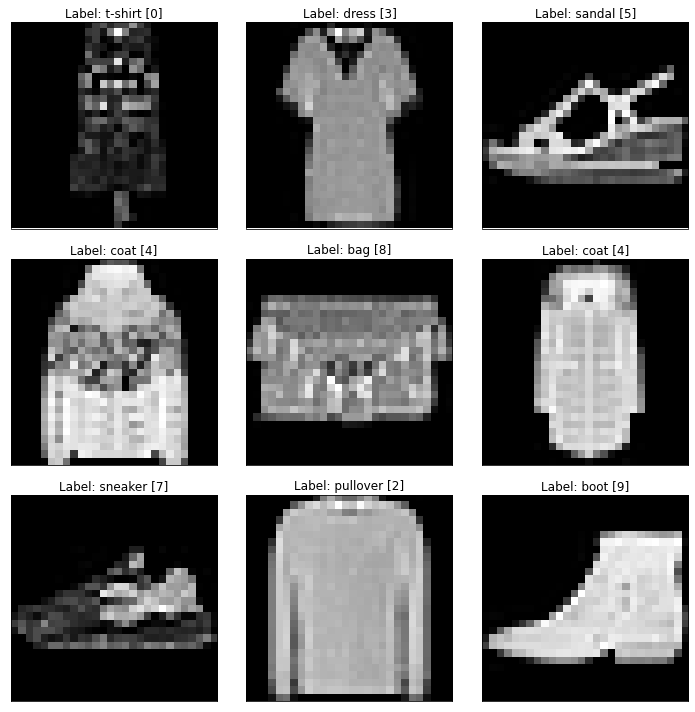

In [12]:

fig, axs = plt.subplots(3, 3, figsize=(10,10))
for ax in axs.flatten(): 
    img, label = random.choice(train_dataset_full)
    ax.imshow(np.array(img[0]), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [13]:
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset_full, [int(0.8*len(train_dataset_full)),int(0.2*len(train_dataset_full))])

print('Train samples:', len(train_dataset), '\nValidation samples:', len(valid_dataset), '\nTest samples:', len(test_dataset))

train_load = Data.DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_load = Data.DataLoader(valid_dataset, batch_size=256, shuffle=False)

test_load  = Data.DataLoader(test_dataset, batch_size=256, shuffle=False)

batch_data, batch_labels = next(iter(train_load))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_load))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

Train samples: 48000 
Validation samples: 12000 
Test samples: 10000
TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


In [ ]:
loss_func = nn.MSELoss()
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction="minimize", pruner=pruner)
study.enqueue_trial({'encoded_space_dim': 98, 'n_channels': 10, 'optimizer': 'Adam', 
                     'learning_rate': 1e-3, 'weight_decay': 1e-6, 'momentum': 0.8})
study.optimize(objective, n_trials=50)

[I 2022-08-28 13:46:04,921] A new study created in memory with name: no-name-42ddcc07-b50c-4921-826e-c225ef0c381f
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\ipykernel_launcher.py:5: ExperimentalWarning: enqueue_trial is experimental (supported from v1.2.0). The interface can change in the future.
  """
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\optuna\study\study.py:857: ExperimentalWarning: create_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\optuna\study\study.py:857: ExperimentalWarning: add_trial is experimental (supported from v2.0.0). The interface can change in the future.
  create_trial(state=TrialState.WAITING, system_attrs={"fixed_params": params})
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using:

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-28 16:05:54,406] Trial 0 finished with value: 0.012403162196278572 and parameters: {'encoded_space_dim': 98, 'n_channels': 10, 'optimizer': 'Adam', 'learning_rate': 0.001, 'weight_decay': 1e-06, 'momentum': 0.8}. Best is trial 0 with value: 0.012403162196278572.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 19.7 K
1 | decoder   | Sequential | 19.8 K
2 | loss_func | MSELoss    | 0     
-----------------------------

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-28 18:14:57,347] Trial 1 finished with value: 0.014874172396957874 and parameters: {'encoded_space_dim': 89, 'n_channels': 5, 'optimizer': 'Adam', 'learning_rate': 0.0009222687989793008, 'weight_decay': 5.751452959117597e-06, 'momentum': 0.8594690046380445}. Best is trial 0 with value: 0.012403162196278572.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 21.5 K
1 | decoder   | Sequential | 21.6 K
2 | loss_func | MSE

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-28 20:16:19,568] Trial 2 finished with value: 0.12631310522556305 and parameters: {'encoded_space_dim': 66, 'n_channels': 6, 'optimizer': 'sgd', 'learning_rate': 0.0005917299800757217, 'weight_decay': 6.438480203306825e-06, 'momentum': 0.664841888571316}. Best is trial 0 with value: 0.012403162196278572.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 21.3 K
1 | decoder   | Sequential | 21.4 K
2 | loss_func | MSELos

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-29 11:14:33,603] Trial 3 finished with value: 0.012735485099256039 and parameters: {'encoded_space_dim': 63, 'n_channels': 6, 'optimizer': 'Adam', 'learning_rate': 0.0016329040913692708, 'weight_decay': 1.116379541672493e-06, 'momentum': 0.7999411754158958}. Best is trial 0 with value: 0.012403162196278572.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 22.7 K
1 | decoder   | Sequential | 22.8 K
2 | loss_func | MSE

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-29 12:38:02,291] Trial 4 finished with value: 0.015865132212638855 and parameters: {'encoded_space_dim': 84, 'n_channels': 6, 'optimizer': 'Adam', 'learning_rate': 0.0005522372885598417, 'weight_decay': 1.9969641015776637e-05, 'momentum': 0.6081758256516479}. Best is trial 0 with value: 0.012403162196278572.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 36.0 K
1 | decoder   | Sequential | 36.3 K
2 | loss_func | MS

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-29 14:14:16,270] Trial 5 finished with value: 0.138508141040802 and parameters: {'encoded_space_dim': 58, 'n_channels': 10, 'optimizer': 'sgd', 'learning_rate': 0.00016130903854687028, 'weight_decay': 3.282107244086688e-05, 'momentum': 0.7015023664132565}. Best is trial 0 with value: 0.012403162196278572.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 32.9 K
1 | decoder   | Sequential | 33.1 K
2 | loss_func | MSELo

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-29 15:54:57,261] Trial 6 finished with value: 0.1243458017706871 and parameters: {'encoded_space_dim': 72, 'n_channels': 9, 'optimizer': 'sgd', 'learning_rate': 0.004808468925280357, 'weight_decay': 4.559833105138192e-05, 'momentum': 0.6159845003538186}. Best is trial 0 with value: 0.012403162196278572.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 18.4 K
1 | decoder   | Sequential | 18.5 K
2 | loss_func | MSELoss

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-29 17:35:05,073] Trial 7 finished with value: 0.12431693822145462 and parameters: {'encoded_space_dim': 69, 'n_channels': 5, 'optimizer': 'sgd', 'learning_rate': 0.0030952290338217446, 'weight_decay': 1.0719882539006907e-05, 'momentum': 0.828663745222371}. Best is trial 0 with value: 0.012403162196278572.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 17.9 K
1 | decoder   | Sequential | 18.0 K
2 | loss_func | MSELo

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-29 19:15:36,911] Trial 8 finished with value: 0.018996771425008774 and parameters: {'encoded_space_dim': 61, 'n_channels': 5, 'optimizer': 'Adam', 'learning_rate': 0.0003667768427316067, 'weight_decay': 3.16088621255862e-05, 'momentum': 0.8072486209783954}. Best is trial 0 with value: 0.012403162196278572.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 17.9 K
1 | decoder   | Sequential | 18.0 K
2 | loss_func | MSEL

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-29 20:53:11,630] Trial 9 finished with value: 0.02054404653608799 and parameters: {'encoded_space_dim': 61, 'n_channels': 5, 'optimizer': 'Adam', 'learning_rate': 0.00019389927524546534, 'weight_decay': 1.3940570310791148e-06, 'momentum': 0.6688210208437039}. Best is trial 0 with value: 0.012403162196278572.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.8 K
1 | decoder   | Sequential | 31.0 K
2 | loss_func | MS

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-29 22:57:14,472] Trial 10 finished with value: 0.011726069264113903 and parameters: {'encoded_space_dim': 99, 'n_channels': 8, 'optimizer': 'Adam', 'learning_rate': 0.0013085593669425002, 'weight_decay': 2.8421371092728138e-06, 'momentum': 0.895386977352907}. Best is trial 10 with value: 0.011726069264113903.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.8 K
1 | decoder   | Sequential | 30.9 K
2 | loss_func | M

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-30 00:55:47,905] Trial 11 finished with value: 0.011670907028019428 and parameters: {'encoded_space_dim': 98, 'n_channels': 8, 'optimizer': 'Adam', 'learning_rate': 0.0014845015705189926, 'weight_decay': 3.072080036338907e-06, 'momentum': 0.8997910110419747}. Best is trial 11 with value: 0.011670907028019428.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.8 K
1 | decoder   | Sequential | 31.0 K
2 | loss_func | M

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-30 13:16:33,742] Trial 12 finished with value: 0.011579043231904507 and parameters: {'encoded_space_dim': 99, 'n_channels': 8, 'optimizer': 'Adam', 'learning_rate': 0.0017416523427409196, 'weight_decay': 2.9003831355460408e-06, 'momentum': 0.8931385956659423}. Best is trial 12 with value: 0.011579043231904507.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 30.0 K
1 | decoder   | Sequential | 30.2 K
2 | loss_func | 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-30 14:32:42,934] Trial 13 finished with value: 0.01138916052877903 and parameters: {'encoded_space_dim': 87, 'n_channels': 8, 'optimizer': 'Adam', 'learning_rate': 0.00190142706618568, 'weight_decay': 2.8285490992422138e-06, 'momentum': 0.8950793827532456}. Best is trial 13 with value: 0.01138916052877903.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 26.3 K
1 | decoder   | Sequential | 26.4 K
2 | loss_func | MSEL

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-30 16:40:00,493] Trial 14 finished with value: 0.011071615852415562 and parameters: {'encoded_space_dim': 86, 'n_channels': 7, 'optimizer': 'Adam', 'learning_rate': 0.0022398390969494736, 'weight_decay': 3.006756456062436e-06, 'momentum': 0.7370906253304883}. Best is trial 14 with value: 0.011071615852415562.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 25.9 K
1 | decoder   | Sequential | 26.1 K
2 | loss_func | M

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2022-08-30 18:44:00,360] Trial 15 finished with value: 0.015320551581680775 and parameters: {'encoded_space_dim': 80, 'n_channels': 7, 'optimizer': 'Adam', 'learning_rate': 0.0027841670468446576, 'weight_decay': 9.810490586728329e-05, 'momentum': 0.7442249620854811}. Best is trial 14 with value: 0.011071615852415562.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:616: UserWarning: Checkpoint directory C:\Users\alire\OneDrive\Desktop\Projects\no\behy\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 26.5 K
1 | decoder   | Sequential | 26.6 K
2 | loss_func | M

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
C:\Users\alire\OneDrive\Desktop\Envs\python3.7\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trials_df = study.trials_dataframe()
trials_df

In [ ]:
optuna.visualization.plot_optimization_history(study, target_name='Validation loss')

In [ ]:
optuna.visualization.plot_intermediate_values(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study, target_name='Validation loss')

In [ ]:
best_params = study.best_trial.params
print(best_params)

In [ ]:
loss_func = nn.MSELoss()
AE_net = AutoEncoder(best_params)

img, _ = test_dataset[0]
img = img.unsqueeze(0)
print('Original image shape:', img.shape)
img_enc = AE_net.encoder(img)
print('Encoded image shape:', img_enc.shape)
img_enc = AE_net.forward(img)
print('Encoded image shape (forward pass):', img_enc.shape)
dec_img = AE_net.decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

AE_net.to(device)
AE_net.configure_loss(loss_func)

trainer = pl.Trainer(gpus=0, max_epochs=40, progress_bar_refresh_rate=2, 
                     callbacks=[EarlyStopping(monitor='valid_loss')])

In [ ]:
trainer.fit(AE_net, train_load, valid_load)

In [ ]:
trainer.test(AE_net, test_load)

In [ ]:
trainer.save_checkpoint("best_net_checkpoints.ckpt")

In [ ]:
if torch.cuda.is_available():
    AE_net.cuda()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(8,6))


for ax in axs:
    img, label = random.choice(test_dataset)
    img1 = img[0]
    with torch.no_grad():
        encoded_img  = AE_net.encoder(img.unsqueeze(0).to(device))
        decoded_img  = AE_net.decoder(encoded_img)
    
    ax[0].imshow(np.array(img1), cmap='gist_gray')
    ax[0].set_title('Original, Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[1].set_title('Reconstructed, Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    img, label = random.choice(test_dataset)
    img1 = img[0]
    with torch.no_grad():
        encoded_img  = AE_net.encoder(img.unsqueeze(0).to(device))
        decoded_img  = AE_net.decoder(encoded_img)
    
    ax[2].imshow(np.array(img1), cmap='gist_gray')
    ax[2].set_title('Original, Label: %d' % label)
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    ax[3].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[3].set_title('Reconstructed, Label: %d' % label)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    
plt.tight_layout()

In [ ]:
img, label = random.choice(train_dataset)

x_gaussian   = AddGaussianNoise(0., 0.5)(img)
x_saltpepper = AddSaltPepperNoise(s_vs_p=0.5, amount=0.1)(img)

all_noises = torchvision.transforms.Compose([AddSaltPepperNoise(s_vs_p=.5, amount=.05),
                                              AddGaussianNoise(0., 0.5) ])

x_all_noise = all_noises(img)

fig, ax = plt.subplots(1, 4, figsize=(8,2))

ax[0].imshow(np.array(img[0]), cmap='gist_gray')
ax[1].imshow(x_gaussian.squeeze(0).data.numpy(), cmap='gist_gray')
ax[2].imshow(x_saltpepper.squeeze(0).data.numpy(), cmap='gist_gray')
ax[3].imshow(x_all_noise.squeeze(0).data.numpy(), cmap='gist_gray')

ax[0].set_title('Original, Label: %d' % label)
ax[1].set_title('Gaussian')
ax[2].set_title('Salt & Pepper')
ax[3].set_title('Combined noise') 

for axs in ax:
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_xticklabels([])
    axs.set_yticklabels([])

fig.suptitle("Noise Types", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
noisy_train = Dataset_noise(noise_transform=all_noises, dataset=train_dataset)
noisy_valid = Dataset_noise(noise_transform=all_noises, dataset=valid_dataset)
noisy_test  = Dataset_noise(noise_transform=None, dataset=test_dataset)

noisy_train_load = Data.DataLoader(noisy_train, batch_size=256, shuffle=True, num_workers=0)
noisy_valid_load = Data.DataLoader(noisy_valid, batch_size=256, shuffle=False, num_workers=0)
noisy_test_load  = Data.DataLoader(noisy_test, batch_size=256, shuffle=False, num_workers=0)

In [ ]:
denoiser = Denoiser(best_params)

img, _ = test_dataset[0]
img = img.unsqueeze(0)
print('Original image shape:', img.shape)
img_enc = denoiser.encoder(img)
print('Encoded image shape:', img_enc.shape)
img_enc = denoiser.forward(img)
print('Encoded image shape (forward pass):', img_enc.shape)
dec_img = denoiser.decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

In [ ]:
loss_func = nn.MSELoss()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

denoiser.to(device)
denoiser.configure_loss(loss_func)

trainer = pl.Trainer(gpus=0, max_epochs=40, progress_bar_refresh_rate=5, 
                     callbacks=[EarlyStopping(monitor='valid_loss')])

In [ ]:
trainer.fit(denoiser, noisy_train_load, noisy_valid_load)

In [ ]:
trainer.test(denoiser, noisy_test_load )

In [ ]:
if torch.cuda.is_available():
    denoiser.cuda()

In [ ]:
fig, axs = plt.subplots(3, 6, figsize=(12,8))
for ax in axs:
    img, label = random.choice(test_dataset)
    img1 = img[0]
    ax[0].imshow(np.array(img1), cmap='gist_gray')
    ax[0].set_title('Original, Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    
    img1 = img1 + np.random.normal(0, 1, size=img1.shape)
    ax[1].imshow(np.array(img1), cmap='gist_gray')
    ax[1].set_title('Noisy, Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    img = img.unsqueeze(0).to(device)
    denoiser.eval()
    with torch.no_grad():
        encoded_img  = denoiser.encoder(img)
        decoded_img  = denoiser.decoder(encoded_img)
    ax[2].imshow(np.array(decoded_img.cpu()[0][0]), cmap='gist_gray')
    ax[2].set_title('Decoded, Label: %d' % label)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    
    img, label = random.choice(train_dataset)
    img1 = img[0]
    ax[3].imshow(np.array(img1), cmap='gist_gray')
    ax[3].set_title('Original, Label: %d' % label)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    img1 = img1 + np.random.normal(0, 1, size=img1.shape)
    ax[4].imshow(np.array(img1), cmap='gist_gray')
    ax[4].set_title('Noisy, Label: %d' % label)
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    
    img = img.unsqueeze(0).to(device)
    denoiser.eval()
    with torch.no_grad():
        encoded_img  = denoiser.encoder(img)
        decoded_img  = denoiser.decoder(encoded_img)
    ax[5].imshow(np.array(decoded_img.cpu()[0][0]), cmap='gist_gray')
    ax[5].set_title('Decoded, Label: %d' % label)
    ax[5].set_xticks([])
    ax[5].set_yticks([])
    
plt.tight_layout()

In [ ]:
pre_net = AutoEncoder.load_from_checkpoint(checkpoint_path="best_net_checkpoints.ckpt", params=best_params)
fine_tuner = Supervised_decoder(best_params['encoded_space_dim'], pre_net)

for param in fine_tuner.encoder.parameters():
    param.requires_grad = False

loss_func_NLL = torch.nn.NLLLoss()

fine_tuner.configure_loss(loss_func_NLL)
fine_tuner.to(device)

In [ ]:
trainer = pl.Trainer(gpus=0, max_epochs= 40, progress_bar_refresh_rate=5, 
                     callbacks=[EarlyStopping(monitor='valid_loss')])

trainer.fit(fine_tuner, train_load, valid_load)

In [ ]:
trainer.test(fine_tuner, test_load)

In [ ]:
encoded_samples = []

for img, label in tqdm(test_dataset):
    
    img = img.unsqueeze(0).to(device)
    AE_net.eval()    
    with torch.no_grad():
        encoded_img  = AE_net.encoder(img)
    
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples[0]

In [ ]:
encoded_samples_df = pd.DataFrame(encoded_samples)
encoded_samples_df

In [ ]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from plotnine import *
from plotnine.data import mpg
%matplotlib inline

n_components = 2
pca = PCA(n_components=n_components)
pca.fit(encoded_samples_df)
columns = [ f'Enc. Variable {i}' for i in range(n_components)]
compressed_samples = pd.DataFrame( pca.transform(encoded_samples_df), 
                                  columns=columns )

(ggplot(compressed_samples)
 + aes(x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples_df.label.astype(str))
 + geom_point()
 + labs(title="CAE PCA")
)


In [ ]:

encoded_samples = pd.DataFrame(encoded_samples)

n_components = 2
tsne = TSNE(n_components=n_components)
tsne.fit(encoded_samples_df)
columns = [ f'Enc. Variable {i}' for i in range(n_components)]
compressed_samples = pd.DataFrame( tsne.fit_transform(encoded_samples_df), 
                                   columns=columns )
(ggplot(compressed_samples)
 + aes(x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples_df.label.astype(str))
 + geom_point()
 + labs(title="CAE t-SNE")
)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8,6))

img, label = random.choice(test_dataset)
img1 = img[0]
with torch.no_grad():
    encoded_img  = AE_net.encoder(img.unsqueeze(0).to(device))
    decoded_img  = AE_net.decoder(20*torch.randn_like(encoded_img).to(device) )

ax[0].imshow( decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
ax[0].set_title('Generated sample by CAE' )
ax[0].set_xticks([])
ax[0].set_yticks([])

with torch.no_grad():
    decoded_img  = AE_net.decoder(20*torch.randn_like(encoded_img).to(device) )

ax[1].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
ax[1].set_title('Generated sample by CAE' )
ax[1].set_xticks([])
ax[1].set_yticks([])

with torch.no_grad():
    decoded_img  = AE_net.decoder(20*torch.randn_like(encoded_img).to(device) )

ax[2].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
ax[2].set_title('Generated sample by CAE' )
ax[2].set_xticks([])
ax[2].set_yticks([])    
    
plt.tight_layout()

In [ ]:
vae = VariationalAE(best_params)

loss_func = nn.MSELoss()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)
vae.configure_loss(loss_func, 1e-5)

In [ ]:
trainer = pl.Trainer(gpus=0, max_epochs=40, progress_bar_refresh_rate=10, 
                     callbacks=[EarlyStopping(monitor='valid_loss')])
trainer.fit(vae, train_load, valid_load)

In [ ]:
trainer.test(vae, test_load)

In [ ]:
trainer.save_checkpoint("vae.ckpt")

In [ ]:
vae = VariationalAE.load_from_checkpoint("vae.ckpt", params=best_params).to(device)

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(10,8))

for ax in axs:
    img, label = random.choice(test_dataset)
    img1 = img[0]
    with torch.no_grad():
        encoded_img  = vae.forward(img.unsqueeze(0).to(device))
        decoded_img  = vae.decoder(encoded_img)
    
    ax[0].imshow(np.array(img1), cmap='gist_gray')
    ax[0].set_title('Original, Label: %d' % label)
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[1].set_title('Reconstructed, Label: %d' % label)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    img, label = random.choice(test_dataset)
    img1 = img[0]
    with torch.no_grad():
        encoded_img  = vae.forward(img.unsqueeze(0).to(device))
        decoded_img  = vae.decoder(encoded_img)
    
    ax[2].imshow(np.array(img1), cmap='gist_gray')
    ax[2].set_title('Original, Label: %d' % label)
    ax[2].set_xticks([])
    ax[2].set_yticks([])

    ax[3].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[3].set_title('Reconstructed, Label: %d' % label)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    
    
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10,8))

img, label = random.choice(test_dataset)
img1 = img[0]
with torch.no_grad():
    encoded_img  = vae.forward(img.unsqueeze(0).to(device))
    decoded_img  = vae.decoder(15*torch.randn_like(encoded_img).to(device) )

ax[0].imshow( decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
ax[0].set_title('Generated sample by VAE' )
ax[0].set_xticks([])
ax[0].set_yticks([])

with torch.no_grad():
    decoded_img  = vae.decoder(15*torch.randn_like(encoded_img).to(device) )

ax[1].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
ax[1].set_title('Generated sample by VAE' )
ax[1].set_xticks([])
ax[1].set_yticks([])

with torch.no_grad():
    decoded_img  = vae.decoder(15*torch.randn_like(encoded_img).to(device) )

ax[2].imshow(decoded_img.squeeze().cpu().numpy(), cmap='gist_gray')
ax[2].set_title('Generated sample by VAE' )
ax[2].set_xticks([])
ax[2].set_yticks([])    
    
plt.tight_layout()

In [ ]:
vae = VariationalAE.load_from_checkpoint("vae.ckpt", params=best_params).to(device)

In [ ]:
encoded_samples = []

for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]

    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.forward(img)
    
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

In [ ]:
encoded_samples_df = pd.DataFrame(encoded_samples)

n_components = 2
pca = PCA(n_components=n_components)
pca.fit(encoded_samples_df)
columns = [ f'Enc. Variable {i}' for i in range(n_components)]
compressed_samples = pd.DataFrame( pca.transform(encoded_samples_df), 
                                  columns=columns )
(ggplot(compressed_samples)
 + aes(x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples_df.label.astype(str))
 + geom_point()
 + labs(title="VAE PCA")
)

In [ ]:

n_components = 2
tsne = TSNE(n_components=n_components)
tsne.fit(encoded_samples_df)
columns = [ f'Enc. Variable {i}' for i in range(n_components)]
compressed_samples = pd.DataFrame( tsne.fit_transform(encoded_samples_df), 
                                   columns=columns )
(ggplot(compressed_samples)
 + aes(x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples_df.label.astype(str))
 + geom_point()
 + labs(title="VAE t-SNE")
)
